# Okay... so... 

Change which agents you choose partner from


-> also... ........ Vary it for downstream analysis?

In [4]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns
import pandas as pd

import scipy.stats
import datetime
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

import networkx as nx

import joblib

# utility functions

### setup_p_txns

In [5]:
# Note: scipy norm has stddev = 1, mean of 0
# Below shows why we pick max_std_devs = 5
p_txn = scipy.integrate.quad(
        scipy.stats.norm.pdf, -5, 5)[0] # quad() Returns: value, error
print('In total we will capture this amount of the gaussian: ', p_txn)
    
DEBUG = False

def setup_p_txns(total_steps):
    # Mean at 0
    max_std_devs = 5 # 

    if True:
        # Note: scipy norm has stddev = 1, mean of 0
        # Below shows why we pick max_std_devs = 5
        p_txn = scipy.integrate.quad(
                scipy.stats.norm.pdf, -5, 5)[0] # quad() Returns: value, error
        print('In total we will capture this amount of the gaussian: ', p_txn)
    
    txn_probabilities = np.ones(total_steps) * -1

    std_dev_per_step = 2 * max_std_devs / total_steps

    for step in range(total_steps):
        p_txn = \
            scipy.integrate.quad(
                scipy.stats.norm.pdf, 
                -max_std_devs + step * std_dev_per_step, 
                -max_std_devs + (step+1) * std_dev_per_step
            ) # returns: (integration) value, error
        txn_probabilities[step] = p_txn[0]
        if DEBUG:
            print(step, p_txn[0])
    # The peak should be at 0, not halfway through)
    zeroing_shift = int(np.round(txn_probabilities.shape[0] / 2))
    shifted = np.concatenate(
            (txn_probabilities[-zeroing_shift:], 
            txn_probabilities[:-zeroing_shift]))

    if False:
        # DEBUG: In txn time plot,
        # Should see peaks exactly at the means for each type of agent
        txn_probabilities[0] = 1 # set p_txn to 1 to always transact
        txn_probabilities[1:-1] = 0.01 # or Zero

    return shifted 

In total we will capture this amount of the gaussian:  0.9999994266968564


# agent

In [6]:
class BankAgent(ap.Agent):
    def setup(self):
        self.type = None 
        self.pair_amts = None 
        
        # -- param for who to partner 
        self.pair_probs = None
        # -- param for whether to txn 
        self.mean_num_txns = None 
        self.txn_probabilities = None 
        self.send_txn_times = []
        # -- store info
        self.txns = None
        self.txns_list = []
        # -- parmeters for amt $$$
        self.txn_amt_rng = None 
        self.acct_balance = None 
        self.txn_amts = None

    def setup_txn_amts(self, mean=0, stddev=1, total_steps=0):
        self.txn_amts = self.txn_amt_rng.normal(
            loc=mean, scale=stddev, 
            size=total_steps)
        self.txn_amts = np.abs(self.txn_amts)

    # NOTE: Timesteps start at 1 # TODO: fix bug. where first timestep should be at midnight.
    # TODO: fix so stored txn time can be timestep, not timestep-1
    # TOOD: issue currently is graph has both midnight 10/31 and midngith 11/1
    # TODO: due to resample rounding up or down or something idk
    def transact(self, timestep):
        # using as index, subtract (timestep starts at 1)
        p_txn = self.txn_probabilities[timestep-1] * self.mean_num_txns

        if np.random.random() < p_txn and self.acct_balance > 0:
            # using as value, do nothing
            self.send_txn_times.append(timestep) 
            # randomly choose partner (w. probability per parameters)
            if np.random.random() < self.pair_probs['self']:
                my_partner = self.model.agents.select(
                    self.model.agents.type==self.type).random()
            else: # TODO: can only accept two agent types at the moment, using !=
                my_partner = self.model.agents.select(
                    self.model.agents.type!=self.type).random()

            my_partner = my_partner.to_list()[0] 
            # randomly choose amount
            # right now, only scaled by sender
            # so normal will still send large amount to suspicious
            # TODO: vary by receiver also
            amount = self.txn_amts[timestep-1] * self.pair_amts#[self.type]

            # calculations
            my_partner.acct_balance += amount
            self.acct_balance -= amount

            if DEBUG: # DEBUG
                print(
                    f' Transaction @ step: {timestep} with ptxn: {p_txn:.2f}, '
                    f'${amount:.2f} from: {self.id}->{my_partner.id}, '
                    f'({self.type} to {my_partner.type}), new balance: {self.acct_balance:.1f}'
                )

            # Note that txn_type is redundant info (e.g. can be derived from +/- of amount)
            self.txns_list.append([ timestep, 'send', self.id, self.type,
                my_partner.id, my_partner.type, -amount, self.acct_balance])
            # -- also record in partner's txn table 
            my_partner.txns_list.append([
                timestep, 'receive', self.id, self.type, 
                    my_partner.id, my_partner.type, amount, my_partner.acct_balance])

    def cleanup(self):
        self.txns = pd.DataFrame(self.txns_list,
            columns=['timestep', 'txn_type', 'sender_id', 'sender_type', 
            'receiver_id', 'receiver_type', 'amount', 'acct_balance',] )

# parameters

In [7]:
# -- overall model run parameters
NUM_AGENTS_PER_TYPE = {
    'normal': 1000,
    'suspicious': 10,
}
# -- other
# set up agent type txn
#     'network_randomness': 0.5
#     'number_of_neighbors': 2,
# -- TODO
AGENT_TYPE_INIT_NUM_FRIENDS = { # i guess... number of neighbors ... but ... 
    'normal': '5',
    'suspicious': '2'
}

AGENT_TYPE_MAKE_NEW_FRIENDS = {
    'normal': '0.5',
    'suspicious': '0.5'
}
# -- end TODO

AGENT_TYPE_PAIR_PROBS = {
    # these are send probabilities
    'normal': { 
        'self': 0.9, 
        'suspicious': 0.1
    },
    'suspicious': {
        'self': 0.7,
        'normal': 0.3
    }
}
MEAN_TXN_HRS = {'normal':14, 
                'suspicious':22}

MINS_PER_STEP = 15

MEAN_TXN_AMOUNTS = {'normal':250, 
                'suspicious':50} # this shoudl actually vary...

MEAN_NUM_TXNS = {
    'normal':4,
    'suspicious':10
}

parameters = {
    'mean_num_txns':MEAN_NUM_TXNS,
    'mean_txn_amounts':MEAN_TXN_AMOUNTS,
    'num_agents_per_type': NUM_AGENTS_PER_TYPE,
    'agent_type_pair_probs':AGENT_TYPE_PAIR_PROBS,
    'mean_txn_hrs': MEAN_TXN_HRS,
    'mean_txn_amounts ': MEAN_TXN_AMOUNTS,
    'mean_txns': 4, # avg num txns each agent makes
    'starting_balance': 100,
    'seed': 42,
    'mins_per_step' : MINS_PER_STEP, # 1 hr
    'steps': int(24 * (60/MINS_PER_STEP)), # 24 hours * steps per hr
}

# For plotting
def timestep_to_time(timestep):
    date_and_time = datetime.datetime(2022, 10, 31, 0, 0, 0)
    time_elapsed = timestep * (parameters['mins_per_step'])
    time_change = datetime.timedelta(minutes=time_elapsed)
    new_time = date_and_time + time_change
    return new_time

# scratch

# model

In [8]:
class BankModel(ap.Model):
    def setup(self):
        self.p_txns = setup_p_txns(self.p.steps) 
        num_agents = sum(self.p.num_agents_per_type.values())
        
        # Setup up rng to generate seeds for rngs for agents
        rng = np.random.default_rng(self.p.seed)
        agent_rng_seeds = rng.random(num_agents).round(3) * 1000
        agent_rng_seeds = np.array(agent_rng_seeds, dtype=int)

        self.agents = ap.AgentList(self) 

        # -- shift the probabilitiy tables
        for type in ['normal', 'suspicious']:
            hrs_mean = self.p.mean_txn_hrs[type]
            # shift in steps
            # originally peak at 0, now peak at (mean time)
            shift_amt = hrs_mean * int(60 / self.p.mins_per_step)
            shifted = np.concatenate(
                (self.p_txns[-shift_amt:], self.p_txns[:-shift_amt]))
            agents = ap.AgentList(
                self, self.p.num_agents_per_type[type], BankAgent)
            pair_probs = self.p.agent_type_pair_probs[type] 
            agents.mean_num_txns = self.p.mean_num_txns[type]
            agents.pair_probs = pair_probs
            agents.pair_amts = self.p.mean_txn_amounts[type] # todo: not paired atm
            agents.txn_probabilities = shifted
            agents.total_steps = self.p.steps 
            agents.acct_balance = 100
            agents.type = type

            self.agents += agents

        if DEBUG:
            print('here are all the agetns: ')
            print(self.agents)
            print([(agent.id,agent.type) for agent in self.agents])

        # -- calcuations for txn $$$ (each agent gets different seed)
        txn_amt_rngs = ap.AttrIter(
            [np.random.default_rng(seed) for seed in agent_rng_seeds])
        self.agents.txn_amt_rng = txn_amt_rngs

        for agent in self.agents:
            agent.setup_txn_amts(
                mean=20, stddev=5, total_steps=self.p.steps)

    def step(self):
        self.agents.transact(self.t)

    def update(self):
        pass
        '''
        if DEBUG:
            total_txns = 0
            for agent in self.agents:
                num_txns = agent.txns[agent.txns.txn_type == 'send'].shape[0]
                total_txns += num_txns
            print('num txns (across all agents)', total_txns)
        '''

    def end(self):
        # i think this includes the final timestep t = 96 as entire column
        self.agents.record('send_txn_times')
        
        # export data
        for agent in self.agents:
            agent.cleanup()

# scratch

In [9]:
# https://github.com/JoelForamitti/agentpy/blob/master/tests/test_sequences.py
tmp_model = BankModel()
agents = ap.AgentList(tmp_model, 10, BankAgent)
agents.random(5).type = 'test'
agents.id
for agent in agents:
    print(agent.id, agent.type)
agents.select(agents.type=='test').random().id

1 None
2 None
3 None
4 test
5 test
6 test
7 test
8 test
9 None
10 None


[4]

In [10]:
np.random.default_rng(42).normal()

0.30471707975443135

# run

In [11]:
model = BankModel(parameters)
results = model.run()

In total we will capture this amount of the gaussian:  0.9999994266968564
Completed: 96 steps
Run time: 0:00:00.529163
Simulation finished


# Plot

In [12]:
# For plotting
def timestep_to_time(timestep):
    date_and_time = datetime.datetime(2022, 10, 31, 0, 0, 0)
    time_elapsed = timestep * (parameters['mins_per_step'])
    time_change = datetime.timedelta(minutes=time_elapsed)
    new_time = date_and_time + time_change
    return new_time

In [13]:
if DEBUG:
    for agent in model.agents:
        print(agent.txns)
display(model.agents[0].txns)

,timestep,txn_type,sender_id,sender_type,receiver_id,receiver_type,amount,acct_balance
0,42,receive,83,normal,1,normal,4772.408134,4872.408134
1,50,receive,160,normal,1,normal,5167.647633,10040.055767
2,54,send,1,normal,378,normal,-5130.963272,4909.092495
3,65,send,1,normal,295,normal,-5391.946528,-482.854033


In [14]:
# transaction amount, sender, receiver, timestamp

In [15]:
results.info

{'model_type': 'BankModel',
 'time_stamp': '2022-12-16 10:21:43',
 'agentpy_version': '0.1.5',
 'python_version': '3.10.',
 'experiment': False,
 'completed': True,
 'created_objects': 1010,
 'completed_steps': 96,
 'run_time': '0:00:00.529163'}

In [16]:
# okay so now i want to... uh... okay histogram plot of when txns are occuring
# then i want to ... make a network of who transacted with who

In [17]:
if DEBUG:
    model.agents.acct_balance

In [18]:
#sns.histplot(model.agents.acct_balance)
model.agents[0].txns#.where('txn_type
#model.agents.txns.shape
#model.agents.txns[1]

,timestep,txn_type,sender_id,sender_type,receiver_id,receiver_type,amount,acct_balance
0,42,receive,83,normal,1,normal,4772.408134,4872.408134
1,50,receive,160,normal,1,normal,5167.647633,10040.055767
2,54,send,1,normal,378,normal,-5130.963272,4909.092495
3,65,send,1,normal,295,normal,-5391.946528,-482.854033


In [19]:
all_txns = []
for agent in model.agents:
    #print(agent.id, 'with txns at timesteps: ',  agent.send_txn_times)
    #print('aka times: ') 

    for timestamp in agent.send_txn_times:
        #print( timestep_to_time(timestamp).strftime('%H:%M'))
        all_txns.append(timestep_to_time(timestamp))
    #print('the partners were: ', agent.txns[agent.txns.txn_type =='send'].receiver_id)
all_txns = pd.DataFrame( all_txns, columns=['send_txn_times' ])
all_txns.sort_values(by='send_txn_times')

,send_txn_times
1905,2022-10-31 00:15:00
1900,2022-10-31 00:15:00
1856,2022-10-31 00:30:00
1878,2022-10-31 00:30:00
1868,2022-10-31 00:30:00
...,...
1887,2022-10-31 23:30:00
1904,2022-10-31 23:45:00
1899,2022-10-31 23:45:00
1877,2022-10-31 23:45:00


In [20]:
if DEBUG:
    with np.printoptions(precision=3, suppress=True):
        display(model.agents[0].txn_probabilities)

In [21]:
all_txns.index = all_txns.send_txn_times
resampled = all_txns.send_txn_times.resample('15Min')#.count().plot()
#resampled = all_txns.send_txn_times.resample('1H')#.count().plot()
resampled.count()
df = pd.DataFrame(resampled.count())
df.columns=['num_txns']
df['labels'] = pd.to_datetime(df.index).strftime('%H:%M')

(<Figure size 576x720 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

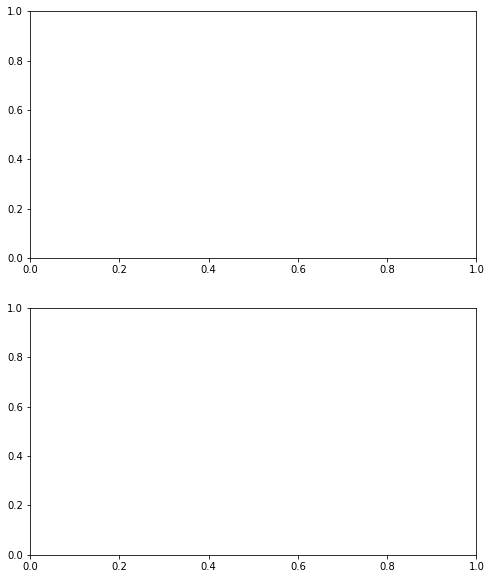

In [22]:
plt.subplots(2,1, figsize=(8,10))


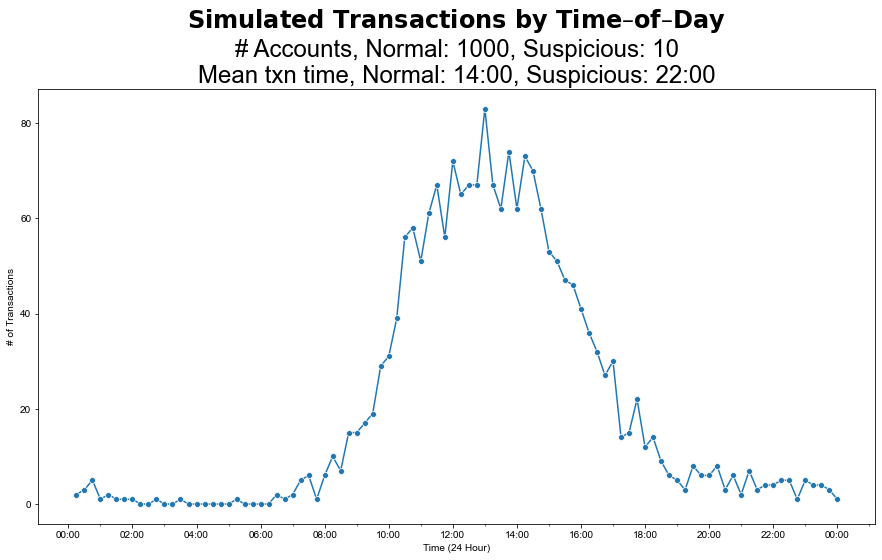

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(x='send_txn_times', y='num_txns', data=df, ax=ax,
    markers=True,  marker='o')

# -- 
# format
sns.set_style('whitegrid')
sns.set_context('poster')

ax.set(xlabel='Time (24 Hour)', ylabel='# of Transactions',
# add title 
title=r"$\bf{Simulated\ Transactions\ by\ Time–of–Day}$" 
    f"\n# Accounts, Normal: {parameters['num_agents_per_type']['normal']}, "
    f"Suspicious: {parameters['num_agents_per_type']['suspicious']}\n"
    f"Mean txn time, Normal: {parameters['mean_txn_hrs']['normal']}:00,"
    f" Suspicious: {parameters['mean_txn_hrs']['suspicious']}:00"
    )

# 
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

# calculate node and edge list

In [24]:
results.variables['suspicious']

,,send_txn_times
obj_id,t,
1001,96,"[2, 5, 14, 74, 81, 83, 85, 86, 87, 88, 90, 93]"
1002,96,"[2, 3, 7, 82, 84, 85, 87, 90, 92, 95]"
1003,96,"[2, 3, 75, 78, 81, 83, 85, 91, 93, 94]"
1004,96,"[3, 6, 8, 11, 68, 83, 85, 88, 92, 93, 94, 95]"
1005,96,"[1, 81, 92, 93, 95]"
1006,96,"[1, 82, 84, 85, 89, 90, 94, 96]"
1007,96,"[4, 71, 81, 83, 86, 87, 88, 89, 90]"
1008,96,"[5, 71, 81, 83, 86, 89, 92]"
1009,96,"[3, 73, 78, 79, 80, 89, 90]"


In [25]:
results.variables['normal']

,,send_txn_times
obj_id,t,
1,96,"[54, 65]"
2,96,[51]
3,96,[34]
4,96,[68]
5,96,[53]
...,...,...
996,96,[62]
997,96,"[41, 42, 47, 68, 72]"
998,96,"[47, 60]"


In [26]:
all_txns_2 = [] 
for agent in model.agents:
    sends = agent.txns[agent.txns['txn_type'] == 'send']
    all_txns_2.append(sends)

all_txns_2[0]
df_2 = pd.concat(all_txns_2)
edges_list = df_2[['sender_id', 'receiver_id']].to_numpy()

In [27]:
#G=nx.Graph()
G=nx.DiGraph()
G.add_edges_from(edges_list)

In [28]:
G.number_of_nodes()
G.number_of_edges()

1925

In [29]:
model.agents[0].type

'normal'

In [30]:
df_2 # all transcations with amts etc. 

,timestep,txn_type,sender_id,sender_type,receiver_id,receiver_type,amount,acct_balance
2,54,send,1,normal,378,normal,-5130.963272,4909.092495
3,65,send,1,normal,295,normal,-5391.946528,-482.854033
1,51,send,2,normal,590,normal,-5104.439404,779.990493
0,34,send,3,normal,827,normal,-5098.651905,-4998.651905
2,68,send,4,normal,1009,suspicious,-5296.373698,7375.646096
...,...,...,...,...,...,...,...,...
29,85,send,1010,suspicious,1006,suspicious,-1403.180260,105384.721359
30,87,send,1010,suspicious,1001,suspicious,-1367.083779,104017.637580
31,88,send,1010,suspicious,1009,suspicious,-867.571129,103150.066451
32,89,send,1010,suspicious,1006,suspicious,-760.731586,102389.334865


In [31]:
# -- give up
#counts = df_2[df_2.sender_type =='normal'][['receiver_type', 'sender_id']]
#counts = counts.groupby('sender_id').value_counts()
#counts = counts.reset_index()
#counts.rename(columns={0:'value_count'})
#df_2[df_2.sender_type =='normal'][['receiver_type', 'sender_id']].pivot('' , values=counts)
#df_2[df_2.sender_type =='suspicious'][['receiver_type', 'sender_id']].groupby('sender_id').value_counts()
#df_2[df_2.sender_type =='suspicious'][['receiver_type', 'sender_id']].groupby('sender_id').value_counts()


In [32]:
counts = df_2[['sender_type', 'receiver_type', 'sender_id']]
counts = counts.groupby('sender_id').value_counts()
counts = counts.reset_index()
counts = counts.rename(columns={0:'value_count'})
display(counts.sender_type.unique())
display(counts.receiver_type.unique())

array(['normal', 'suspicious'], dtype=object)

array(['normal', 'suspicious'], dtype=object)

In [33]:
counts.groupby(['sender_type', 'receiver_type']).sum().apply(np.average)

sender_id      145795.25
value_count       486.25
dtype: float64

In [34]:
counts

,sender_id,sender_type,receiver_type,value_count
0,1,normal,normal,2
1,2,normal,normal,1
2,3,normal,normal,1
3,4,normal,suspicious,1
4,5,normal,normal,1
...,...,...,...,...
1140,1008,suspicious,suspicious,5
1141,1008,suspicious,normal,2
1142,1009,suspicious,suspicious,5
1143,1009,suspicious,normal,2


# confirm that pairs parnters are distributed correctly
normal-normal should be greater than normal-suspicious, etc.

In [35]:
avgs = {}
pair_cts = {}
for s_type in counts.sender_type.unique():
    pair_cts[s_type] = {}
    for r_type in counts.receiver_type.unique():
        tmp = counts[(counts.sender_type == s_type) & (counts.receiver_type == r_type)]
        pair_cts[s_type][r_type] = np.average(tmp['value_count'])
pair_cts = pd.DataFrame(pair_cts)
pair_cts
#pairs = zip(counts.sender_type.unique(), counts.receiver_type.unique())
#list(pairs)
# pairs: for normal senders: what are avg # reciever, avg # suspicious 



,normal,suspicious
normal,1.752880,2.444444
suspicious,1.064327,6.700000


In [37]:
df_2['timestep_to_time'] = df_2['timestep'].apply(timestep_to_time)
# for classiifcation, I want: timestamp, sender, reciver, sendertype, amount
# would be useful: if avg account balance is small overall / kept near zero

# export tabular data

In [38]:
# timestep is particular to this run, todo: refactor it out (need for 
# classification at the moment)
tabular_data = df_2[['timestep', 'timestep_to_time', 'sender_id', 'receiver_id', 'sender_type', 'amount'] ]
tabular_data.to_csv('txns_list.csv', index=False)


In [39]:
df_2[['sender_id', 'sender_type']].drop_duplicates('sender_id').to_csv('agents_list.csv', index=False)

# export network metadata

In [40]:
G.out_degree[1]
G.in_degree[1]

2

In [41]:
#display(pd.DataFrame(G.out_degree).head())
#display(pd.DataFrame(G.in_degree).head())
df_out_deg = pd.DataFrame(G.out_degree(), columns=['node_id', 'out_degree'])
df_in_deg = pd.DataFrame(G.in_degree(), columns=['node_id', 'in_degree'])
df_degs = pd.merge(df_in_deg, df_out_deg, on='node_id' )
df_degs.to_csv(
    'tabular_graph_features.csv', index=False)

In [42]:
display(df_degs.sort_values(by='node_id'))

,node_id,in_degree,out_degree
0,1,2,2
3,2,2,1
5,3,2,1
7,4,2,1
9,5,0,1
...,...,...,...
38,1006,17,6
126,1007,21,8
52,1008,34,7
8,1009,21,7


In [43]:
# in degrees and out degrees for each node
#pd.DataFrame(G.out_degree(), columns=['node_id', 'out_degree']).to_csv(
    #'tabular_graph_features.csv', index=False)

In [44]:
#  json.dump(json_data, outfile)
# TypeError: Object of type int64 is not JSON serializable

# json does not recognize NumPy data types. Convert the number to a Python int before serializing the object:

# https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable
# json.dumps(data, default=str)
# Excellent solution. However, one drawback is that numpy arrays are returned without delimiter, e.g. '[0 1 3]'.

# export networkx graph

In [45]:
G.out_degree()
print(type(nx.cytoscape_data(G)))
import json as json

json_data = nx.cytoscape_data(G) 
with open('exported_cytoscape_network.json', 'w', 
encoding='utf-8') as outfile: 
    outfile.write(str(json_data))

<class 'dict'>


In [50]:
#G.nodes()[1]['type']

In [51]:
# https://memgraph.com/memgraph-for-networkx?utm_source=networkx-guide&utm_medium=referral&utm_campaign=networkx_ppp&utm_term=visualization%2Bbasics&utm_content=visualizeiteasy

# https://plotly.com/python/network-graphs/
# https://stackoverflow.com/questions/72621067/how-to-show-the-result-of-networkx-graph-in-plotly-dash-using-dash-callbacks
# https://networkx.org/documentation/networkx-1.10/reference/drawing.html

In [52]:
G.nodes()
[n for n in G.neighbors(1)] # 1 is the node index

colors = []
for i in range(len(G.nodes())):
    acct_type = model.agents[i].type
    G.nodes[i+1]['type'] =  model.agents[i].type
    if acct_type == 'normal' :
        colors.append('white')
    else:
        colors.append('red')

KeyError: 584

In [53]:
edges_list
pd.DataFrame(edges_list, 
    columns=['nx_node_A', 'nx_node_B']).to_csv(
        'nx_edges_list.csv', index=False)

np.savetxt('nx_edges_list.csv', edges_list)

In [ ]:
# G.nodes['type'] == 'normal'

In [2]:
# https://networkx.guide/visualization/basics#layouts
#types = [ node[1]['type'] for node in G.nodes(data=True) ]
#nx.draw(G, with_labels = True, node_color = colors, 
#arrows=False)
# spiral layout, spring layout are the other options

nx.draw(G, with_labels = True, node_color = colors, pos=nx.shell_layout(G))
nx.draw(G.nodes['type']) =  model.agents[i].type
plt.show()

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (1036992258.py, line 8)

In [ ]:
#import ipycytoscape
#fig = ipycytoscape.CytoscapeWidget()
#fig.graph.add_graph_from_networkx(G)
#fig
# currently takes too long !

In [ ]:
# https://github.com/plotly/dash-cytoscape/issues/23

In [ ]:
#display(cy)

In [ ]:
# https://stackoverflow.com/questions/71428375/dash-cytoscape-from-python-networks-graph-not-honouring-the-nodes-coordinates